In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

2023-11-16 14:25:46.774488: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 14:25:46.813690: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 14:25:47.018043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 14:25:47.018086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 14:25:47.019592: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
ds = tfds.load("fashion_mnist", split="train")

## Visualise the dataset

In [7]:
data_iterator = ds.as_numpy_iterator()

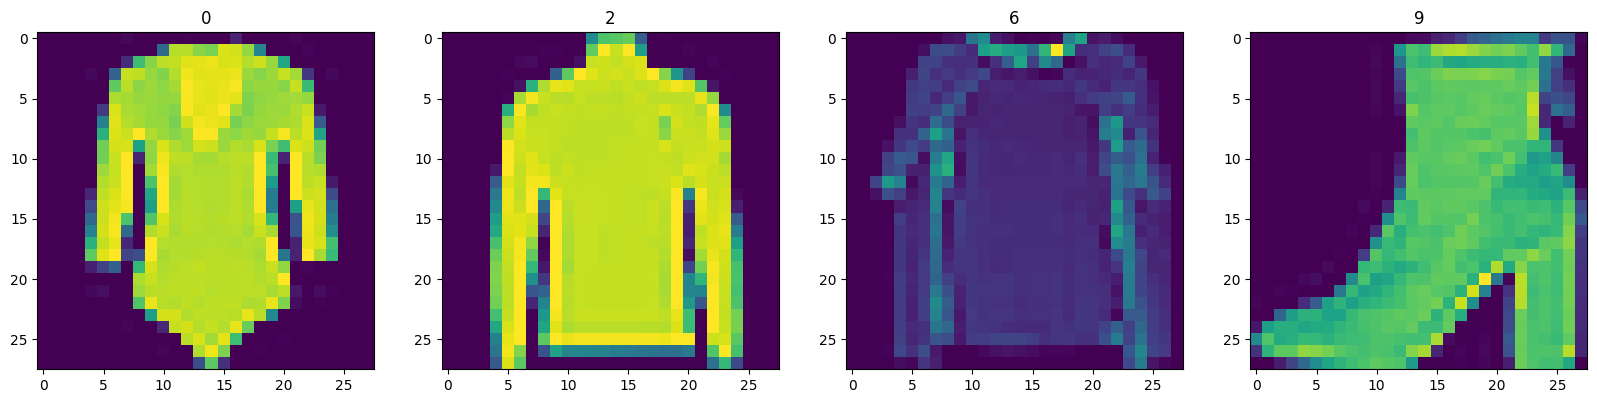

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch["image"]))
    ax[idx].title.set_text(batch["label"])

In [3]:
def scale_image(data):
    image = data["image"]
    return image/255

### build network

In [4]:
ds = tfds.load("fashion_mnist", split="train")
ds = ds.map(scale_image)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build generator

In [6]:
def build_generator():
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))

    # upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    # conv layer to convet to 1 channel
    model.add(Conv2D(1, 4, padding="same", activation="sigmoid"))

    return model

In [17]:
import cv2

In [7]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [8]:
img = generator.predict(np.random.randn(4, 128, 1))
img

1/1 [==============================] - 0s 120ms/step


array([[[[0.50076884],
         [0.51017004],
         [0.5148546 ],
         ...,
         [0.50980234],
         [0.5100404 ],
         [0.5055234 ]],

        [[0.49377045],
         [0.5037584 ],
         [0.5159077 ],
         ...,
         [0.5079646 ],
         [0.50917435],
         [0.49835294]],

        [[0.4854879 ],
         [0.48867512],
         [0.498719  ],
         ...,
         [0.5053695 ],
         [0.4986898 ],
         [0.49206537]],

        ...,

        [[0.50577784],
         [0.4995594 ],
         [0.49445415],
         ...,
         [0.48901185],
         [0.4959963 ],
         [0.4957849 ]],

        [[0.50574607],
         [0.5038927 ],
         [0.5017811 ],
         ...,
         [0.4947076 ],
         [0.49436763],
         [0.49575743]],

        [[0.5059571 ],
         [0.50378317],
         [0.50157714],
         ...,
         [0.5019807 ],
         [0.49921596],
         [0.49922916]]],


       [[[0.4895216 ],
         [0.49324706],
         [0.49

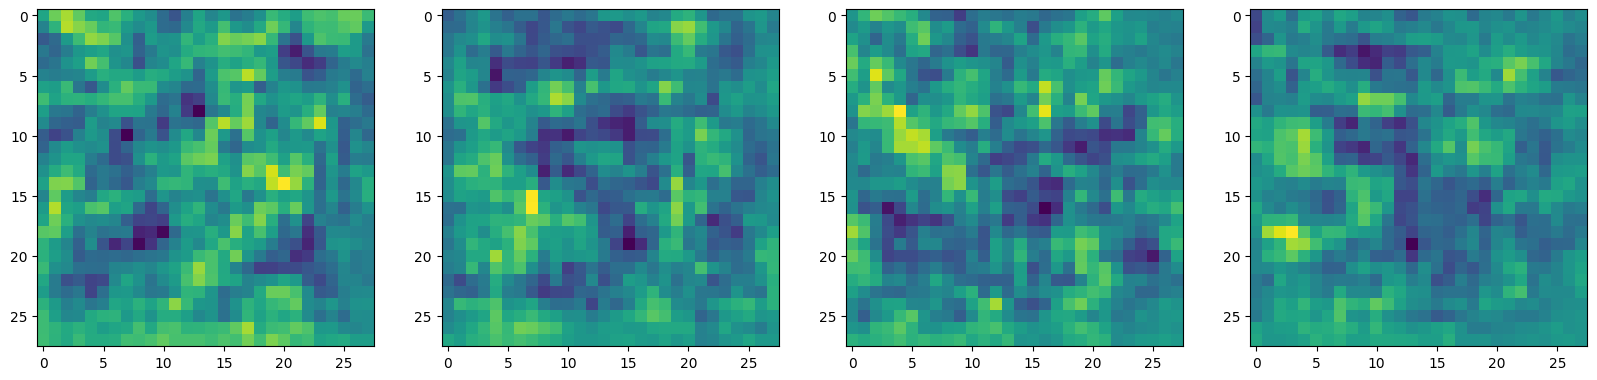

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, im in enumerate(img):
    ax[idx].imshow(im)

Build Descriminator

In [8]:
def build_descriminator():
    model = Sequential()

    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))


    return model

In [9]:
des_model = build_descriminator()
des_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [12]:
des_model.predict(img)

1/1 [==============================] - 0s 55ms/step


array([[0.49674192],
       [0.49676046],
       [0.49672672],
       [0.49678564]], dtype=float32)

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [11]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [12]:
from tensorflow.keras.models import Model

In [13]:
class FashionGan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super(FashionGan, self).__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss



    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)

            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # labels for real and fake
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # adding noise to the outputs
            noise_real = 0.15 *tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))

            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply back propogation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # train the generator
        with tf.GradientTape() as g_tape:
            # generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}




In [14]:
fasgan = FashionGan(generator, des_model)

In [15]:
fasgan.compile(g_opt, d_opt, g_loss, d_loss)

In [16]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [18]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('data/images', f'generated_img_{epoch}_{i}.png'))

In [19]:
hist = fasgan.fit(ds, epochs=1)

2023-11-16 15:07:42.507612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/sequential_1/leaky_re_lu_5/LeakyRelu_1/LeakyReluGrad' exist for missing node 'sequential_1/conv2d_5/BiasAdd_1'.


263/469 [===============>..............] - ETA: 9:11 - d_loss: 0.6011 - g_loss: 1.2280

KeyboardInterrupt: 